<a href="https://colab.research.google.com/github/Inglam/Computer-Vision-EECS442-/blob/master/Enpei_PS9_Panoramic_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EECS 442 PS9: Panoramic Stitching**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Enpei Zhao, zepxyz



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_orb_features (1 point)

2. match_keypoints (1 point)

3. find_homography and transform_ransac (1 point each)

4. panoramic_stitching (1 points)

# Starting

Run the following code to import the modules you'll need. 

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.optimize import least_squares

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

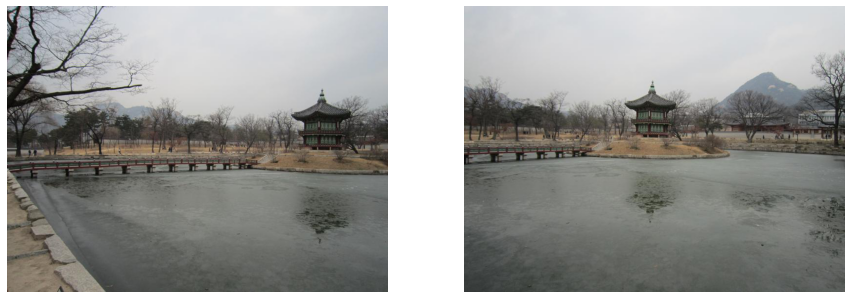

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# (a) Compute ORB Features and Match Keypoints

In [ ]:
def get_orb_features(img):
  '''
    Compute ORB features using cv2 library functions (hint: you will need cv2.ORB_create() and some related functions).  Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
  '''
  # ===============================================
  # TODO
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(img,None)
  # ===============================================
  return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    Compute matches between feature descriptors of two images using ratio test. 
    You may use cv2 library functions.(hint: you may need to use cv2.DescriptorMatcher_create or cv2.BFMatcher and some related functions)
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  # TODO
  bf = cv2.DescriptorMatcher_create("BruteForce")
  results = bf.knnMatch(desc_1, desc_2, 2)
  matches = []
  for x, y in results:
    if x.distance < ratio * y.distance:
        matches.append(x)
  # ===============================================
  return matches

keypoints for img1 and img2


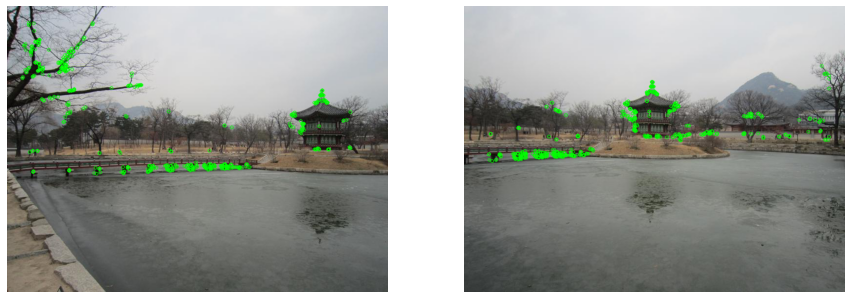

In [ ]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


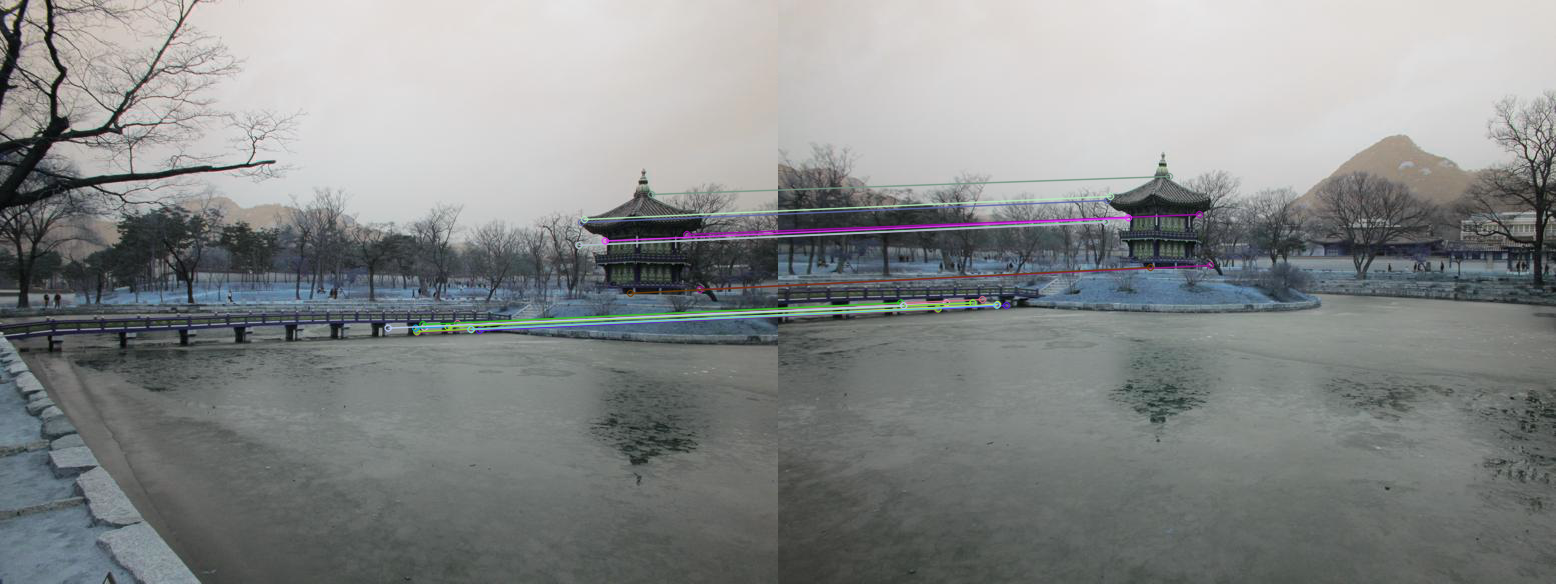

In [ ]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [ ]:
def find_homography(pts_1, pts_2):
  '''
    Use either nonlinear least squares or direct linear transform 
    to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Hint if usinng nonlinear least square: 
      The objective function to optimize here is: ||pts_1 - cart(H*homog(pts_2))||^2 where homog(x) converts x into homogeneous coordinates and cart(x) converts x to cartesian coordinates.
      You can use scipy.optimize.least_squares for this.
    Hint if using direct linear transform: 
      The solution is given by the right-singular vector with the smallest singular value in the singular vector decomposition. 
      You can use np.linalg.svd for this. 
    Input:
      pts_1, pts_2: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  # ===============================================
  # TODO
  def cart(x):
    res = x[:,:2].copy()
    for a in range(res.shape[0]):
        res[a] /= x[a, 2]
    return res

  def homog(x):
    res = np.array(x)
    w = np.ones((res.shape[0],1))
    res = np.concatenate((res, w), 1)
    return res


  def func(H):
    H = np.reshape(H, (3,3))
    res = pts_1 - cart(np.transpose(np.dot(H, np.transpose(homog(pts_2)))))
    return res.flatten()

  H = least_squares(func, np.ones(9)).x
  H = H.reshape(3,3)
  
  # ===============================================
  return H

In [ ]:
def transform_ransac(pts_1, pts_2):
  '''
    Implements RANSAC to estimate homography matrix.
    Hint: Follow the RANSAC steps outlined in the lecture slides.
    Input:
      pts_1, pts_2: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  # TODO
  def cart(x):
      res = x[:,:2].copy()
      for a in range(res.shape[0]):
        res[a] /= x[a, 2]
      return res

  def homog(x):
      res = np.array(x)
      w = np.ones((res.shape[0],1))
      res = np.concatenate((res, w), 1)
      return res

  N = 100
  ep = 2
  max = []
  best = []
  for a in range(N):
    inliers = []
    result = []
    i = np.random.choice(pts_2.shape[0], 4)
    H = find_homography(pts_1[i], pts_2[i])
    temp = pts_1 - cart(np.transpose(np.dot(H, np.transpose(homog(pts_2)))))
    for b in range(temp.shape[0]):
      if abs(np.sum(temp[b])) < ep:
        inliers.append(True)
        result.append(b)
      else:
        inliers.append(False)
    if np.count_nonzero(max) <= np.count_nonzero(inliers):
      best = result
      max = inliers
      result = np.array(result)
      best = np.array(best)

  best_model = find_homography(pts_1[best], pts_2[best])
  # ===============================================
  return best_model

# Panoramic Stitching

In [ ]:
def panoramic_stitching(img1, img2):
  '''
    Given a pair of overlapping images, generate a panoramic image. 
    Hint: use the functions that you've written in the previous parts.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  # TODO
  # ===============================================
  # 1.detect keypoints and extract orb feature descriptors
  # 2.match features between two images
  # 3.compute homography matrix H transforming points from pts_2 to pts_1. Note the order here (not pts_1 to pts_2)!
  key_1, des_1 = get_orb_features(img1)
  key_2, des_2 = get_orb_features(img2)

  matches = match_keypoints(des_1, des_2)

  pts_1, pts_2 = [], []
  for a in range(len(matches)):
    pts_1.append(key_1[matches[a].queryIdx].pt)
    pts_2.append(key_2[matches[a].trainIdx].pt)
  pts_2 = np.array(pts_2)
  pts_1 = np.array(pts_1)
  H = transform_ransac(pts_1, pts_2)

  # apply perspective wrap to stitch images together
  final_img = cv2.warpPerspective(img2, H, (img2.shape[1] + img1.shape[1], img2.shape[0] * 2))
  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

  return final_img


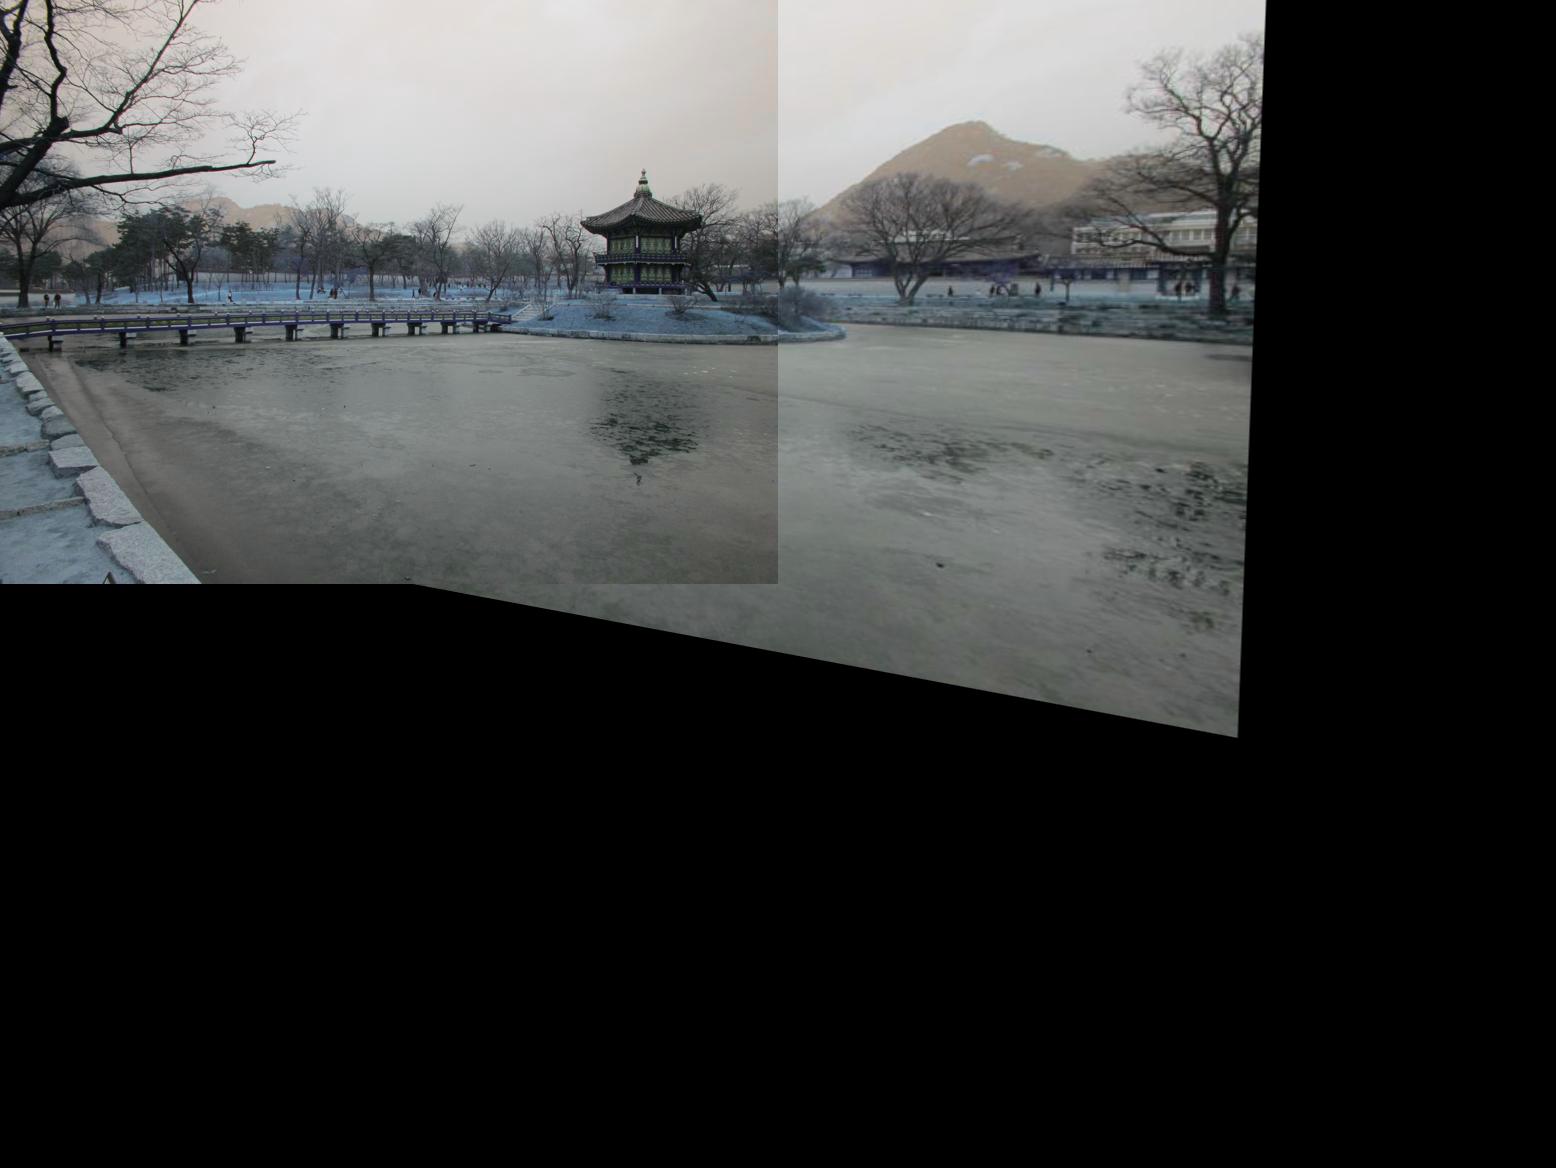

In [ ]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)

# Convert Notebook to PDF


In [ ]:
# generate pdf
# %%capture
!git clone https://gist.github.com/bc5f1add34fef7c7f9fb83d3783311e2.git
!cp bc5f1add34fef7c7f9fb83d3783311e2/colab_pdf.py colab_pdf.py
from colab_pdf import colab_pdf
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
colab_pdf('Enpei_PS9_Panoramic_Stitching.ipynb')

fatal: destination path 'bc5f1add34fef7c7f9fb83d3783311e2' already exists and is not an empty directory.
Mounted at /content/drive/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'